<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

In [4]:
import sklearn
from sklearn import datasets

In [5]:
lfw_pairs = datasets.fetch_lfw_pairs(
    subset='train',
    data_home="/content/drive/MyDrive/Colab Notebooks/lfw",
    funneled=False,
    resize=1,
    color=True,
    # download_if_missing=True
    )
# ref : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_pairs.html

In [6]:
lfw_pairs.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [7]:
pairDevTrain = open("/content/drive/MyDrive/Colab Notebooks/lfw/lfw_home/pairsDevTrain.txt").readlines()[1:]

Nicolas_Lapentti	1	Paula_Dobriansky	1

Different persons


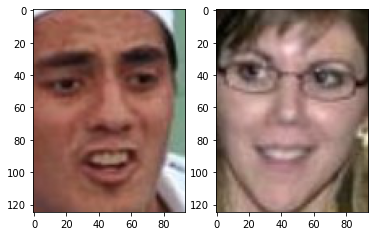

In [8]:
index = 2109
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [10]:
lfw_people = datasets.fetch_lfw_people(
    data_home="/content/drive/MyDrive/Colab Notebooks/LFW",
    min_faces_per_person=2,
    resize=1,
    color=True,
    # download_if_missing=True
)

In [11]:
lfw_people.data.shape

(9164, 35250)

In [12]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [ ]:
np.moveaxis(lfw_people.images, -1,-3).shape

In [ ]:
lfw_people.keys()

In [ ]:
lfw_people.target[46]# .shape

In [ ]:
plt.imshow(lfw_people.images[5] / 255)
lfw_people.target_names[lfw_people.target[5]]

In [ ]:
randomstate = np.random.RandomState(seed=None)

In [ ]:
no_of_classes = len(lfw_people.target_names)

In [ ]:
pos_class = randomstate.choice(no_of_classes)
neg_class = randomstate.choice(no_of_classes)
while pos_class == neg_class:
    neg_class = randomstate.choice(classes_per_batch)
pos_class, neg_class

In [ ]:
pos_name = lfw_people.target_names[pos_class]
neg_name = lfw_people.target_names[neg_class]
pos_name, neg_name

In [ ]:
pos_imgs = lfw_people.images[lfw_people.target == pos_class]
neg_imgs = lfw_people.images[lfw_people.target == neg_class]
pos_imgs.shape[0], neg_imgs.shape[0]

In [ ]:
if pos_imgs.shape[0] == 2:
    ianc, ipos = 0,1
else:
    ianc = randomstate.randint(0, pos_imgs.shape[0])
    ipos = randomstate.randint(0, pos_imgs.shape[0])
    while ianc == ipos:
        ipos = randomstate.randint(0, len(face_classes[pos_class]))

In [ ]:
ineg = randomstate.randint(0, neg_imgs.shape[0])

In [ ]:
ianc

In [ ]:

# Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136

In [ ]:
_,axxar = plt.subplots(1,3)
axxar[0].imshow(pos_imgs[ianc] / 255)
axxar[1].imshow(pos_imgs[ipos] / 255)
axxar[2].imshow(neg_imgs[ineg] / 255)
print(f'Pos_class : {pos_name}, Neg_class : {neg_class}')

In [ ]:
lfw_people.target_names[928]

In [ ]:
triplets = []

In [41]:
def get_random_triplets(no_classes:int, images, target, no_triplets:int):
    # Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136
    randomstate = np.random.RandomState(seed=None)
    # no_class = len(lfw_people.target_names)
    triplets = []
    class_pairs = []

    ###
    # _,axxar = plt.subplots(no_triplets,3, figsize=(7,5))
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
    ###

    # progress_bar = tqdm(range(no_triplets), desc='fetching triplets')
    for progress in range(no_triplets):

        pos_class = randomstate.choice(no_classes)
        neg_class = randomstate.choice(no_classes)
        while pos_class == neg_class:
            neg_class = randomstate.choice(no_classes)

        # pos_name = lfw_people.target_names[pos_class]
        # neg_name = lfw_people.target_names[neg_class]

        pos_imgs = images[target == pos_class]
        neg_imgs = images[target == neg_class]

        if pos_imgs.shape[0] == 2:
            ianc, ipos = 0,1
        else:
            ianc = randomstate.randint(0, pos_imgs.shape[0])
            ipos = randomstate.randint(0, pos_imgs.shape[0])
            while ianc == ipos:
                ipos = randomstate.randint(0, pos_imgs.shape[0])
        ineg = randomstate.randint(0, neg_imgs.shape[0])

        ####
        # axxar[progress][0].imshow(pos_imgs[ianc] / 255)
        # axxar[progress][0].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][1].imshow(pos_imgs[ipos] / 255)
        # axxar[progress][1].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][2].imshow(neg_imgs[ineg] / 255)
        # axxar[progress][2].set_title(lfw_people.target_names[neg_class])
        ####

        triplets.append(
            torch.stack([
                torch.from_numpy(pos_imgs[ianc] / 255), 
                torch.from_numpy(pos_imgs[ipos] / 255), 
                torch.from_numpy(neg_imgs[ineg] / 255)
            ]))
        class_pairs.append((pos_class, neg_class))

    return torch.stack(triplets) , class_pairs

fetching triplets: 100%|██████████| 5/5 [00:00<00:00, 187.59it/s]


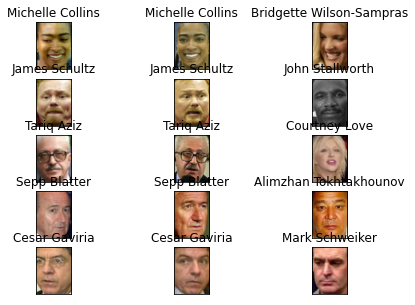

In [ ]:
triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names), images=lfw_people.images, target=lfw_people.target, no_triplets=5)

Text(0.5, 1.0, 'hello')

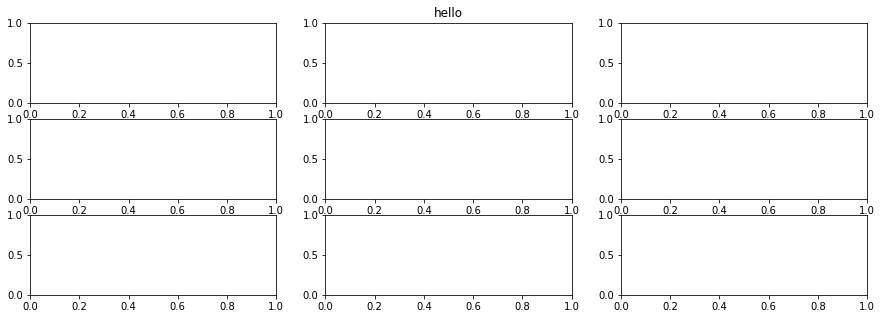

In [ ]:
_,axxar = plt.subplots(3,3, figsize = (15,5))
axxar[0,1].set_title('hello')

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

# Model

In [42]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5))),
                            # ('norm', nn.BatchNorm2d(32)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            # ('norm', nn.BatchNorm2d(64)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            # ('norm', nn.BatchNorm2d(128)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=7680, out_features=2048)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=2048, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))

        # self.out      = nn.Linear(in_features=128, out_features=2)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        # x = x.view(-1, 10*6*128)
        x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [ ]:
x = torch.rand(3, 3, 125, 94, 3)
print(x.shape)
x = x.movedim(-1, -3)
print(x.shape)
print(x[:,0,...].shape)
x = model.convnet1(x[:,0,...])
print(x.shape)
x = model.convnet2(x)
print(x.shape)
x = model.convnet3(x)
print(x.shape)
x = x.view(-1, 10*6*128)
print(x.shape)
x = model.FCs(x)
print(x.shape)
print()
x = torch.rand(3, 3, 125, 94, 3)
# x = x.movedim(-1, -3)
x = model(x)
print(x[0].shape)

torch.Size([3, 3, 125, 94, 3])
torch.Size([3, 3, 3, 125, 94])
torch.Size([3, 3, 125, 94])
torch.Size([3, 32, 57, 42])
torch.Size([3, 64, 26, 18])
torch.Size([3, 128, 10, 6])
torch.Size([3, 7680])
torch.Size([3, 128])

torch.Size([3, 128])


In [ ]:
type(x)

list

In [ ]:
triplet_loss(*x)

tensor(0.1944, grad_fn=<MeanBackward0>)

In [15]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): Re

In [ ]:
lfw_pairs.pairs[:1100].shape

(1100, 2, 125, 94, 3)

In [ ]:
lfw_pairs.pairs[1100:, 0].shape

(1100, 125, 94, 3)

In [16]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [43]:
model = Model().cuda()
learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.TripletMarginLoss(margin=0.2, reduction='mean')

In [44]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [ ]:
del triplets

In [45]:
cost = []

epochs = 10
for epoch in range(epochs):

    triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names),
                                                images=lfw_people.images, 
                                                target=lfw_people.target, no_triplets=500)

    apn = model(triplets.cuda())
    # apn = model(triplets)

    optimizer.zero_grad()
    loss = triplet_loss(*apn)
    # loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}\n')


Epoch:[1/10] , Cost : 0.9687780737876892

Epoch:[2/10] , Cost : 135.411376953125

Epoch:[3/10] , Cost : 1.0807793140411377

Epoch:[4/10] , Cost : 0.9797130823135376

Epoch:[5/10] , Cost : 0.9668472409248352

Epoch:[6/10] , Cost : 0.9542814493179321

Epoch:[7/10] , Cost : 0.9115287065505981

Epoch:[8/10] , Cost : 0.9526483416557312

Epoch:[9/10] , Cost : 0.9039755463600159

Epoch:[10/10] , Cost : 0.9355129599571228



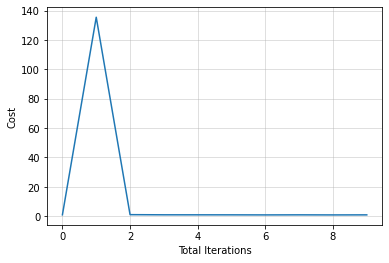

In [46]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [39]:
apn[0].sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [21]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([ 3.9461,  7.2151,  1.3530,  0.8890,  2.0044,  0.2868,  1.8474,  0.1264,
         1.8825,  0.5287,  1.8590,  3.8897,  0.2726,  2.5604,  1.2584,  0.4681,
         1.0699,  2.7831,  0.1913,  2.3122,  4.0491,  0.7951,  4.5279,  0.0457,
         0.6788,  2.7275, 12.1352,  4.0526,  0.6266,  1.3020,  0.4428,  0.4813,
         0.3594,  0.6485,  6.5949,  0.7120,  0.4832,  0.8286,  4.6334,  2.0334,
         4.8857,  0.2202,  6.4351,  0.1894,  1.3609,  1.0568,  0.8097,  2.8326,
         2.2783,  1.1500,  0.2888,  1.5188,  2.0939,  4.6908,  1.0107,  1.5527,
         0.7117,  1.6461,  0.3045,  2.6398,  2.8814,  0.4001,  1.2736,  0.6005,
         2.9190,  0.5235,  0.3272,  2.3912,  3.6134,  0.7881,  0.1016,  3.7425,
         1.4701,  2.9173,  0.9667,  3.8393,  0.1819,  3.3232,  1.1007,  2.1987,
         0.8164,  2.3087,  0.4124,  1.4228,  0.3843,  3.8393,  2.2633,  3.4987,
         1.1948,  0.8755,  2.7533,  4.4166,  0.9942,  2.9411,  0.4142,  1.0486,
         1.6080,  1.7333,  0.9235,  0.91

In [22]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([ 3.8193,  1.2016,  2.8323,  1.4352, 11.4742,  1.3103,  0.8829,  0.9665,
         1.5781,  4.4522,  0.5683,  2.6631,  5.9271, 11.7795,  1.2918,  5.8550,
         4.1742,  5.8915,  2.6695,  4.3461,  0.1906,  1.8150,  0.5389,  2.2461,
        13.0390,  0.3354,  2.1426,  7.2054,  1.2917,  0.7112,  0.4470,  3.0201,
         1.1486,  0.1241,  3.1236, 15.6099,  1.8633,  3.6589,  2.5235, 22.0382,
         0.1910,  5.1311,  1.6387,  0.3673,  1.5532,  3.6689,  5.2821,  4.1379,
         1.4819,  7.4514,  1.5626,  1.5754,  0.5527,  0.8267,  1.1932,  5.5170,
         0.6035,  1.9861,  2.0215,  2.4733,  4.0448,  4.1135,  7.2441,  6.7138,
         3.8757,  1.5686,  0.5647,  8.9273,  5.8026,  1.0362,  0.2704,  0.9714,
         0.4177,  2.7787,  3.5921,  0.3859,  3.4838,  7.6654,  0.2690,  3.6614,
         0.8093,  2.2396,  9.1055,  0.7435,  1.7862,  7.3255,  0.6294,  5.5111,
         1.7832, 10.6451,  1.2106,  2.6494,  9.6485,  2.0747,  3.9782,  8.8793,
         0.4480,  1.1057,  2.3305,  4.22

In [31]:
(p-n)#.std()

tensor([ 1.2678e-01,  6.0136e+00, -1.4792e+00, -5.4620e-01, -9.4698e+00,
        -1.0235e+00,  9.6451e-01, -8.4007e-01,  3.0433e-01, -3.9235e+00,
         1.2907e+00,  1.2265e+00, -5.6545e+00, -9.2191e+00, -3.3435e-02,
        -5.3869e+00, -3.1043e+00, -3.1084e+00, -2.4782e+00, -2.0338e+00,
         3.8585e+00, -1.0199e+00,  3.9890e+00, -2.2004e+00, -1.2360e+01,
         2.3921e+00,  9.9927e+00, -3.1528e+00, -6.6510e-01,  5.9078e-01,
        -4.2194e-03, -2.5388e+00, -7.8913e-01,  5.2445e-01,  3.4712e+00,
        -1.4898e+01, -1.3801e+00, -2.8303e+00,  2.1100e+00, -2.0005e+01,
         4.6947e+00, -4.9110e+00,  4.7964e+00, -1.7792e-01, -1.9229e-01,
        -2.6121e+00, -4.4724e+00, -1.3054e+00,  7.9633e-01, -6.3014e+00,
        -1.2738e+00, -5.6632e-02,  1.5412e+00,  3.8641e+00, -1.8244e-01,
        -3.9642e+00,  1.0826e-01, -3.4008e-01, -1.7169e+00,  1.6651e-01,
        -1.1634e+00, -3.7135e+00, -5.9706e+00, -6.1134e+00, -9.5679e-01,
        -1.0451e+00, -2.3746e-01, -6.5361e+00, -2.1

In [25]:
(F.relu(p-n + 1)).mean()

tensor(1.1440, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [26]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [29]:
index = 14
test1 = torch.from_numpy(lfw_pairs.pairs[index][0]).cuda()
test2 = torch.from_numpy(lfw_pairs.pairs[index][1]).cuda()
enc1 = model.semi_forward(test1.movedim(-1,-3).unsqueeze(0))
enc2 = model.semi_forward(test2.movedim(-1,-3).unsqueeze(0))
d = dist(enc1,enc2)
print(d)
print('Differen Person') if d > 0.5 else print('Same Person')

tensor([0.1089], device='cuda:0', grad_fn=<SumBackward1>)
Same Person


Adolfo_Aguilar_Zinser	1	3

Same person


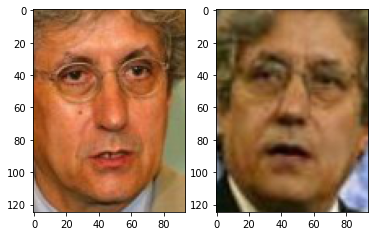

In [30]:
# Testing
# index = 3
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [ ]:
a = next(iter(LOADER))

In [ ]:
a.shape

torch.Size([10, 2, 125, 94, 3])

In [ ]:
model = model.cuda()

In [ ]:
!nvidia-smi

Tue Feb  9 13:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |  11348MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [ ]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese'

In [ ]:
# torch.save(model.state_dict(), PATH)

In [ ]:
ColabCode(port=100, password='12345')

## .

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=ec58767d618243e986be401fd4ad7f2f847e329e53c26d5a9e189caa732dbc32
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


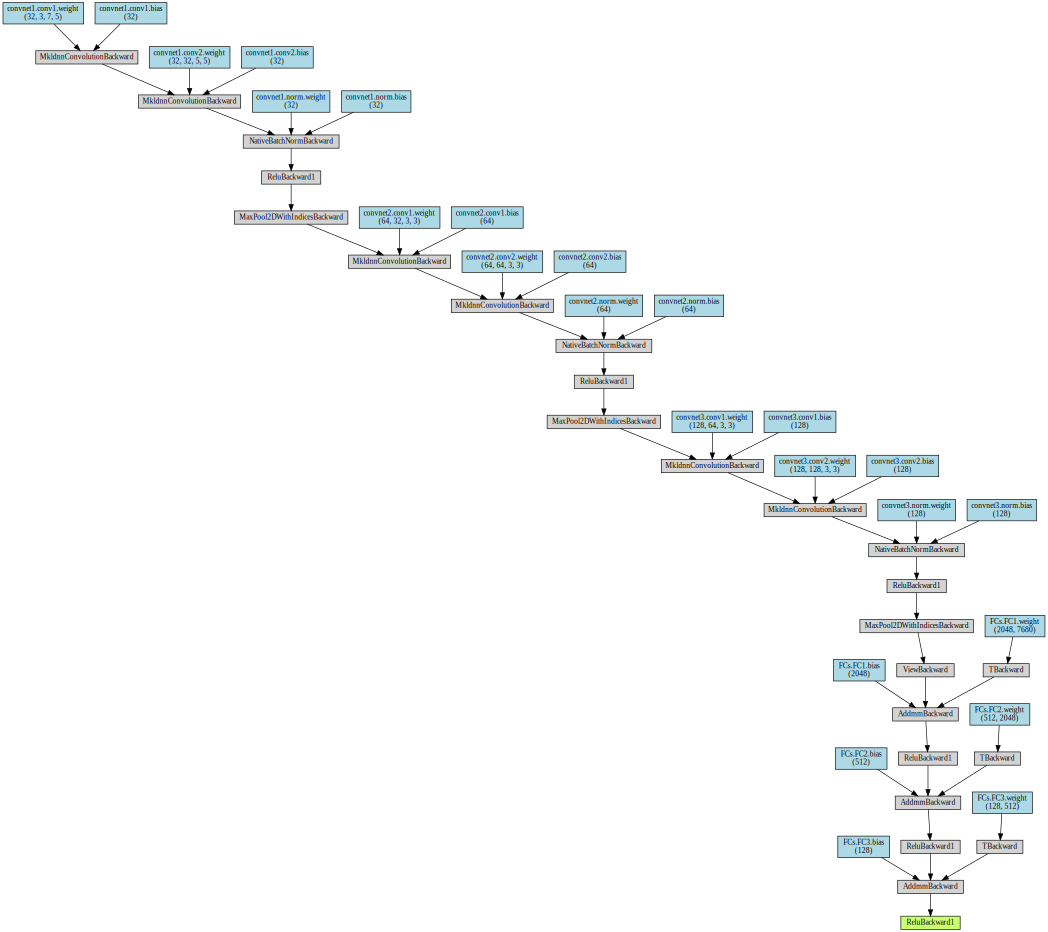

In [ ]:
from torchviz import make_dot

x = torch.randn(10,3,125,94)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-p_6ry_vw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-p_6ry_vw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=6e617219ef97172c7c0ebabb961e1921e232a97f2ff82f92e7c6fa61d14bb0d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfd7y6p/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


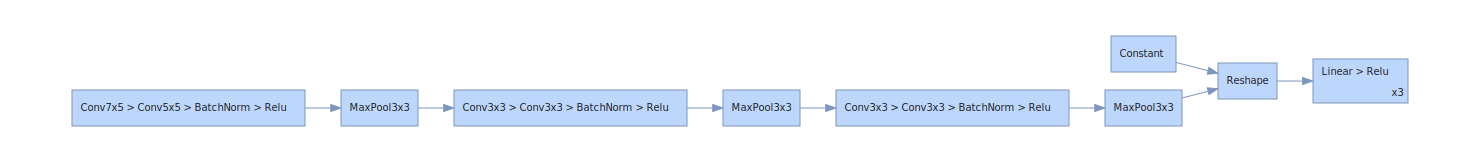

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([10,3,125,94]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

## .

# TensorFlow

In [ ]:
import tensorflow as tf